### Import and Install Libraries


In [1]:
# Install Libraries (Install if needed)
# !apt-get install -y tesseract-ocr
# !pip install pytesseract
# !pip install tqdm
# !pip install tensorflow matplotlib opencv-python-headless
# !pip install easyocr

In [2]:
# System and file handling
import os
import json
import random
from shutil import copyfile
from zipfile import ZipFile

# Data manipulation
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Image processing and visualization
import cv2
from PIL import Image, ImageStat
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# OCR Libraries
import pytesseract
import easyocr

# Deep Learning and Model Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, Compose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, Dense, LSTM, Bidirectional, Input, Flatten, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
import tensorflow as tf

# Warnings
import warnings
warnings.filterwarnings("ignore")

### Collect and Load Data

In [3]:
# Step 1: Mount Google Drive
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
google_drive_path = "/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/"
print(os.listdir(google_drive_path))  # Check for available files

['TextOCR Dataset.zip', 'TextOCR Dataset.zip (Unzipped Files)', 'TextOCR_test_Images_filtered_preprocessed.zip', 'TextOCR_test_Images_filtered.zip']


In [25]:
# Correct path to the dataset
google_drive_zip_path = "/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip" # File Path
unzipped_folder = "/content/unzipped_dataset"

# Unzipping the dataset
def unzip_dataset(zip_path, extract_to):
    """Unzip the dataset to the specified directory."""
    if os.path.exists(zip_path):
        print(f"Extracting dataset from {zip_path}...")
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Dataset extracted to {extract_to}")
    else:
        raise FileNotFoundError(f"Zip file not found at {zip_path}")

# Unzip the dataset
unzip_dataset(google_drive_zip_path, unzipped_folder)

Extracting dataset from /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip...
Dataset extracted to /content/unzipped_dataset


In [8]:
!ls /content/unzipped_dataset

annot.csv  annot.parquet  img.csv  img.parquet	TextOCR_0.1_train.json	train_val_images


In [9]:
!find /content/unzipped_dataset -type d

/content/unzipped_dataset
/content/unzipped_dataset/train_val_images
/content/unzipped_dataset/train_val_images/train_images


### Display Data Images

Displaying the first 20 images from the dataset...


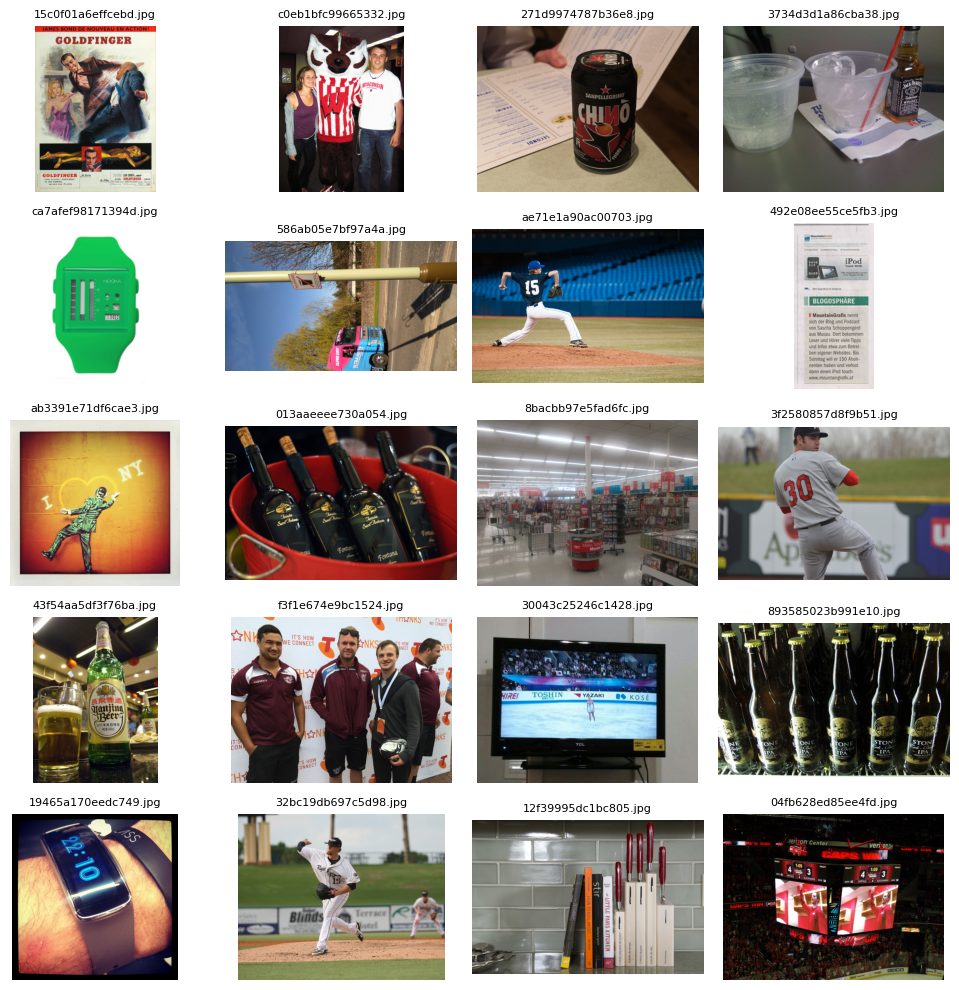

In [10]:
# Update the folder path to the correct image directory
unzipped_folder = "/content/unzipped_dataset/train_val_images/train_images"

# Function to display the first 20 images
def display_sample_images(folder, num_images=20):
    """Display the first `num_images` images from the folder."""
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]
    image_files = image_files[:num_images]  # Limit to the first `num_images`

    if not image_files:
        print("No images found in the folder.")
        return

    # Display images in a grid
    plt.figure(figsize=(10, 10))
    for i, image_name in enumerate(image_files, start=1):
        image_path = os.path.join(folder, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
            plt.subplot(5, 4, i)  # Create a grid of 5 rows and 4 columns
            plt.imshow(image)
            plt.title(image_name, fontsize=8)
            plt.axis('off')
        else:
            print(f"Unable to read image: {image_name}")
    plt.tight_layout()
    plt.show()

# Display the first 20 images
print("Displaying the first 20 images from the dataset...")
display_sample_images(unzipped_folder)

### Data Cleaning

In [13]:
# Filtering Images

# Paths
input_folder = "/content/unzipped_dataset/train_val_images/train_images"  # Path to the folder with train images
output_folder = "/content/test_images"  # Path to save filtered images

# Create output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Quality thresholds for OCR readiness
BRIGHTNESS_THRESHOLD = 50
CONTRAST_THRESHOLD = 20
SHARPNESS_THRESHOLD = 100

# Calculate brightness
def calculate_brightness(image):
    image = Image.fromarray(image)
    stat = ImageStat.Stat(image)
    return stat.mean[0]

# Calculate contrast
def calculate_contrast(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray.std()

# Calculate sharpness
def calculate_sharpness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian

# Evaluate image quality
def evaluate_image_quality(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image at {image_path}. Ensure it is a valid image file.")
    brightness = calculate_brightness(image)
    contrast = calculate_contrast(image)
    sharpness = calculate_sharpness(image)
    return brightness, contrast, sharpness

# Process images for quality filtering
def process_images(input_folder, output_folder):
    results = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

    for image_name in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_name)

        # Skip non-image files
        if not image_name.lower().endswith(valid_extensions):
            print(f"Skipping non-image file: {image_name}")
            continue

        try:
            # Evaluate image
            brightness, contrast, sharpness = evaluate_image_quality(image_path)
            score = (brightness >= BRIGHTNESS_THRESHOLD and
                     contrast >= CONTRAST_THRESHOLD and
                     sharpness >= SHARPNESS_THRESHOLD)
            results.append((image_name, brightness, contrast, sharpness, score))

            # Save image to output folder if it meets the quality criteria
            if score:
                output_path = os.path.join(output_folder, image_name)
                copyfile(image_path, output_path)
        except ValueError as e:
            print(f"Error processing image {image_name}: {e}")

    return results

# Run the image filtering process
print("Filtering images based on quality...")
image_quality_results = process_images(input_folder, output_folder)

# Display results for the first 5 images
print("Sample of filtered image quality results (first 5):")
for result in image_quality_results[:5]:  # Only the first 5 results
    print(f"Image: {result[0]}, Brightness: {result[1]:.2f}, Contrast: {result[2]:.2f}, Sharpness: {result[3]:.2f}, OCR Ready: {result[4]}")

# Summary of the filtering process
print(f"\nTotal images processed: {len(image_quality_results)}")
print(f"Images meeting quality criteria: {sum(1 for r in image_quality_results if r[4])}")

Filtering images based on quality...
Sample of filtered image quality results (first 5):
Image: 15c0f01a6effcebd.jpg, Brightness: 122.62, Contrast: 79.49, Sharpness: 261.99, OCR Ready: True
Image: c0eb1bfc99665332.jpg, Brightness: 88.45, Contrast: 86.37, Sharpness: 532.52, OCR Ready: True
Image: 271d9974787b36e8.jpg, Brightness: 95.24, Contrast: 71.95, Sharpness: 192.78, OCR Ready: True
Image: 3734d3d1a86cba38.jpg, Brightness: 99.54, Contrast: 40.93, Sharpness: 208.70, OCR Ready: True
Image: ca7afef98171394d.jpg, Brightness: 171.84, Contrast: 67.63, Sharpness: 5.07, OCR Ready: False

Total images processed: 25119
Images meeting quality criteria: 19856


### Visual of Images after Data Clean

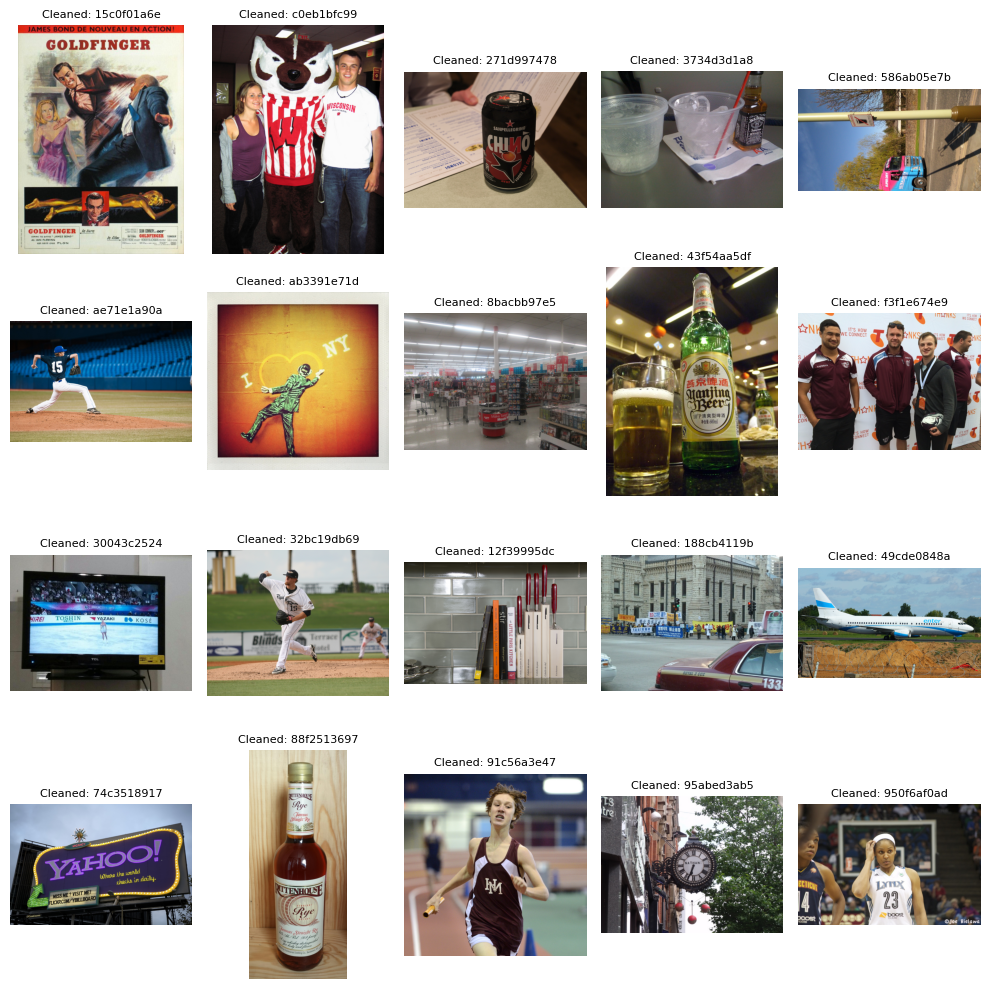

In [14]:
# Display a sample of cleaned images
def display_cleaned_images(folder, num_images=20):
    """
    Displays a sample of cleaned images in a grid layout.
    """
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')  # Define valid image file formats
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]  # Filter valid images
    image_files = image_files[:num_images]  # Limit to the first `num_images`

    if not image_files:
        print("No valid images found in the folder.")
        return

    plt.figure(figsize=(10, 10))  # Adjust figure size for 20 images
    for i, image_name in enumerate(image_files, start=1):
        image_path = os.path.join(folder, image_name)
        image = cv2.imread(image_path)  # Read the image
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            plt.subplot(4, 5, i)  # Create a grid layout: 4 rows x 5 columns
            plt.imshow(image)
            plt.title(f"Cleaned: {image_name[:10]}", fontsize=8)  # Display truncated image name
            plt.axis('off')
        else:
            print(f"Could not read image: {image_name}")

    plt.tight_layout()
    plt.show()

# Display cleaned images
display_cleaned_images("/content/test_images", num_images=20)

### Image Preprocessing

In [15]:
# PreProcess Images

# Define input and output folders
input_folder = 'test_images'
output_folder = 'output_images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

def preprocess_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur for noise reduction
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu's Thresholding for binarization
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Deskew the image
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Rotate the image to deskew
    (h, w) = binary.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed = cv2.warpAffine(binary, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Sharpen the image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(deskewed, -1, kernel)

    # Save preprocessed image
    cv2.imwrite(output_path, sharpened)

# Get the list of image files
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

# Iterate over all images in the input folder with a progress bar
print("Processing images...")
for filename in tqdm(image_files, desc="Preprocessing Images", unit="image"):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)
    preprocess_image(input_path, output_path)

print(f"Preprocessing complete. Preprocessed images are saved in '{output_folder}'.")

Processing images...


Preprocessing Images: 100%|██████████| 19856/19856 [10:53<00:00, 30.36image/s]

Preprocessing complete. Preprocessed images are saved in 'output_images'.


### Exploratory Data Analysis

In [17]:
# Paths
preprocessed_folder = "/content/output_images"  # Folder with preprocessed images
output_csv = "/content/eda_results.csv"  # CSV to save EDA results

# Helper functions for feature extraction
def calculate_brightness(image):
    """Calculate brightness of an image."""
    image = Image.fromarray(image)
    stat = ImageStat.Stat(image)
    return stat.mean[0]

def calculate_contrast(image):
    """Calculate contrast of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray.std()

def calculate_sharpness(image):
    """Calculate sharpness of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian

# Process preprocessed images and extract features
def process_images_for_eda(folder):
    """Extract brightness, contrast, and sharpness for all valid images."""
    data = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]

    # Add progress bar for processing
    for image_name in tqdm(image_files, desc="Analyzing Images", unit="image"):
        image_path = os.path.join(folder, image_name)

        # Read image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Unreadable image file: {image_name}")
            continue

        # Extract features
        try:
            brightness = calculate_brightness(image)
            contrast = calculate_contrast(image)
            sharpness = calculate_sharpness(image)
            height, width = image.shape[:2]
            data.append({
                "Image": image_name,
                "Brightness": brightness,
                "Contrast": contrast,
                "Sharpness": sharpness,
                "Width": width,
                "Height": height,
                "Aspect Ratio": width / height if height > 0 else None
            })
        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

    return pd.DataFrame(data)

Starting EDA...


Analyzing Images: 100%|██████████| 19856/19856 [04:32<00:00, 72.86image/s]


EDA results saved to /content/eda_results.csv
Summary Statistics:
         Brightness      Contrast     Sharpness         Width        Height  \
count  19856.000000  19856.000000  19856.000000  19856.000000  19856.000000   
mean     126.451876    117.093809   6109.881859    946.850876    810.411916   
std       48.177121     13.808318   3657.175102    141.761499    156.002788   
min        0.784935      1.863178     39.530719    256.000000    257.000000   
25%       91.605017    113.325296   3605.387794    939.000000    683.000000   
50%      123.888773    122.628498   5397.736528   1024.000000    768.000000   
75%      160.239267    126.316897   7765.441137   1024.000000   1024.000000   
max      254.985037    127.487515  80042.355850   2560.000000   3008.000000   

       Aspect Ratio  
count  19856.000000  
mean       1.235488  
std        0.364352  
min        0.250000  
25%        0.997070  
50%        1.333333  
75%        1.499268  
max        3.984436  


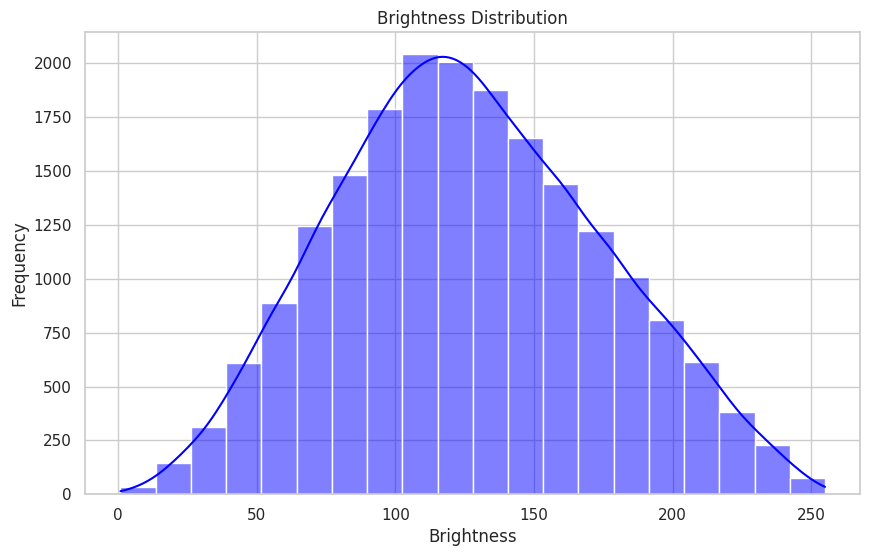

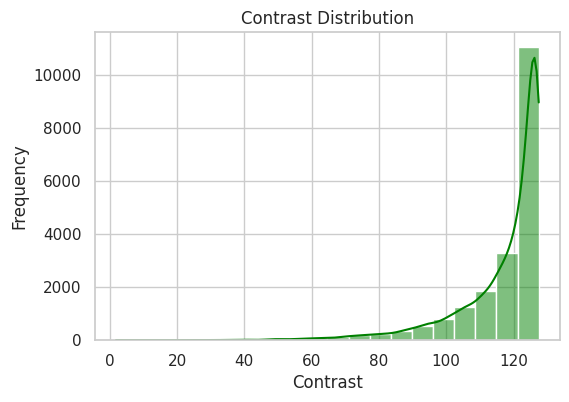

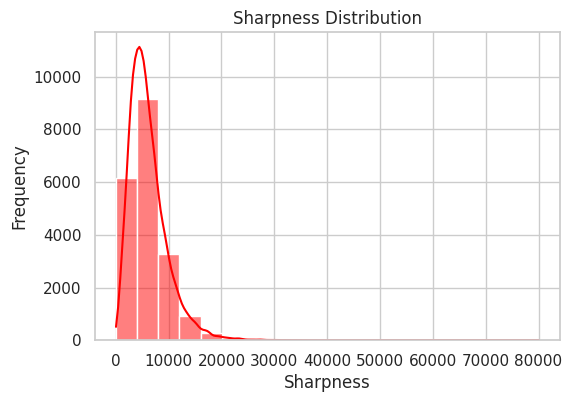

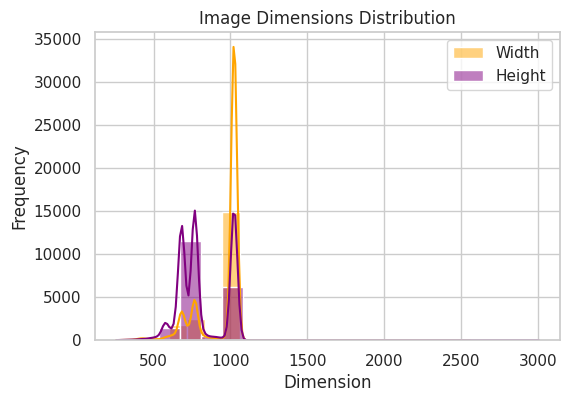

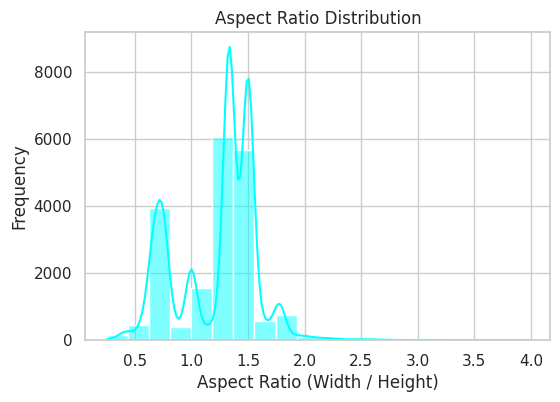

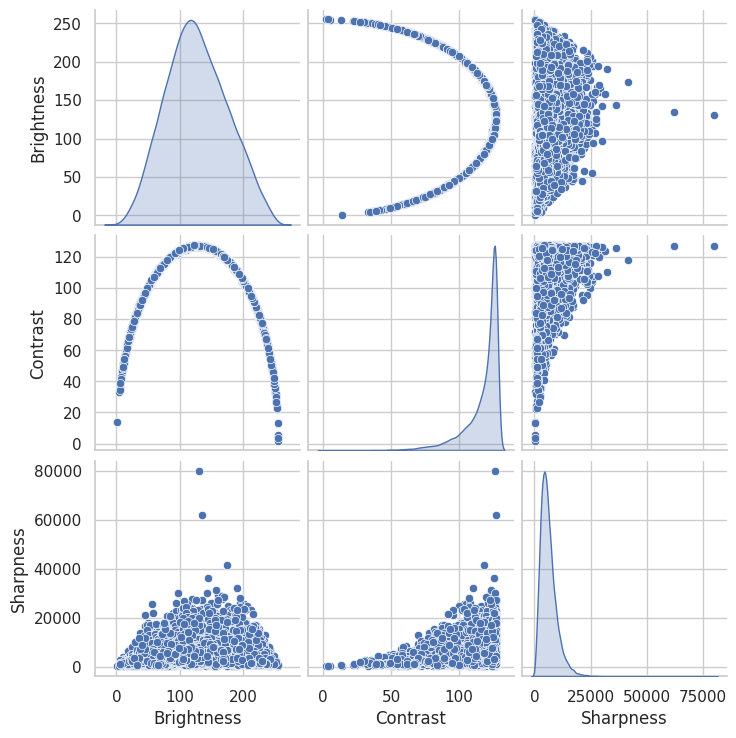

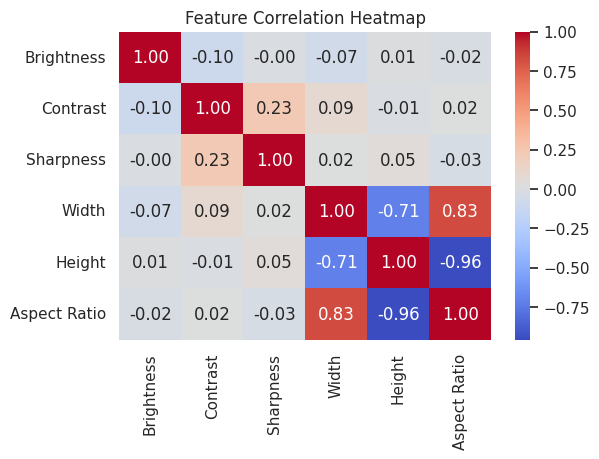

In [18]:
# Extract features from preprocessed images
print("Starting EDA...")
df = process_images_for_eda(preprocessed_folder)

# Save EDA results and perform visualizations
if not df.empty:
    # Save results to CSV
    df.to_csv(output_csv, index=False)
    print(f"EDA results saved to {output_csv}")

    # Summary statistics
    print("Summary Statistics:")
    print(df.describe())

    # Visualizations
    sns.set(style="whitegrid")

    # Brightness Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df["Brightness"], bins=20, kde=True, color="blue")
    plt.title("Brightness Distribution")
    plt.xlabel("Brightness")
    plt.ylabel("Frequency")
    plt.show()

    # Contrast Distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(df["Contrast"], bins=20, kde=True, color="green")
    plt.title("Contrast Distribution")
    plt.xlabel("Contrast")
    plt.ylabel("Frequency")
    plt.show()

    # Sharpness Distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(df["Sharpness"], bins=20, kde=True, color="red")
    plt.title("Sharpness Distribution")
    plt.xlabel("Sharpness")
    plt.ylabel("Frequency")
    plt.show()

    # Image Dimensions Distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(df["Width"], bins=20, kde=True, color="orange", label="Width")
    sns.histplot(df["Height"], bins=20, kde=True, color="purple", label="Height")
    plt.title("Image Dimensions Distribution")
    plt.xlabel("Dimension")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Aspect Ratio Distribution
    plt.figure(figsize=(6, 4))
    sns.histplot(df["Aspect Ratio"], bins=20, kde=True, color="cyan")
    plt.title("Aspect Ratio Distribution")
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Frequency")
    plt.show()

    # Pairplot for relationships
    sns.pairplot(df, vars=["Brightness", "Contrast", "Sharpness"], diag_kind="kde")
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(6, 4))
    corr = df[["Brightness", "Contrast", "Sharpness", "Width", "Height", "Aspect Ratio"]].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()
else:
    print("No valid images processed. Ensure the preprocessed folder contains valid image files.")

### File Directories
Search for Ground Truth files

In [19]:
print("Checking contents of 'Colab Notebooks':")
colab_notebooks_path = "/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset"
print(os.listdir(colab_notebooks_path))


Checking contents of 'Colab Notebooks':
['TextOCR Dataset.zip', 'TextOCR Dataset.zip (Unzipped Files)', 'TextOCR_test_Images_filtered_preprocessed.zip', 'TextOCR_test_Images_filtered.zip']


In [20]:
# Function to find all file paths
def find_all_file_paths(directory, limit_per_dir=5):
    if not os.path.exists(directory):
        print(f"Error: The directory '{directory}' does not exist.")
        return []

    print(f"Finding all file paths in directory: {directory}\n")
    file_paths = []
    for root, dirs, files in os.walk(directory):
        print(f"Current Directory: {root}")

        # Limit the number of files printed per directory
        print(f"  Total Files: {len(files)}")
        print(f"  Listing up to {limit_per_dir} files:")
        for file in files[:limit_per_dir]:
            full_path = os.path.join(root, file)
            file_paths.append(full_path)
            print(f"    - {full_path}")  # Print limited file paths

        print("\n" + "-"*50 + "\n")

    return file_paths

# Specify the TextOCR folder
textocr_folder = "/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)"

# List all file paths with limited print output
all_files = find_all_file_paths(textocr_folder, limit_per_dir=5)

# Output the results
print(f"\nTotal files found in '{textocr_folder}': {len(all_files)}")

Finding all file paths in directory: /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)

Current Directory: /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)
  Total Files: 6
  Listing up to 5 files:
    - /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/TextOCR_0.1_train.json
    - /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/annot.csv
    - /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/annot.parquet
    - /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/img.csv
    - /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/img.parquet

----------------------------------------

### Ground-Truth Files

In [21]:
# Path to the dataset's JSON file
ground_truth_path = "/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/TextOCR_0.1_train.json"

# Load the JSON file
def load_json(path):
    with open(path, 'r') as file:
        data = json.load(file)
    return data

# Extract metadata from "info"
def get_dataset_info(data):
    print("Dataset Info:")
    print(data.get('info', 'No metadata available'))

# Explore images and annotations
def explore_images_and_annotations(data):
    # Get the first image ID
    img_id = list(data['imgToAnns'].keys())[0]

    # Retrieve image details
    image_details = data['imgs'][img_id]
    image_path = image_details.get('file_name', 'No file name available')  # Adjust key based on structure
    print(f"\nImage ID: {img_id}")
    print(f"Image Path: {image_path}")

    # Retrieve annotations associated with the image
    associated_ann_ids = data['imgToAnns'][img_id]
    annotations = [data['anns'][ann_id] for ann_id in associated_ann_ids]
    print(f"Number of Annotations: {len(annotations)}")
    print("Annotations Sample:", annotations[0] if annotations else "No annotations available")

    return image_path, annotations

# Extract complete ground truth for all images
def extract_ground_truth(data, output_file):
    print("\nExtracting ground truth for all images...")
    ground_truth_data = []
    for img_id, ann_ids in data['imgToAnns'].items():
        image_details = data['imgs'][img_id]
        image_path = image_details.get('file_name', 'No file name available')  # Adjust key if needed
        annotations = [data['anns'][ann_id] for ann_id in ann_ids]
        ground_truth_data.append({
            "image_id": img_id,
            "image_path": image_path,
            "annotations": annotations
        })

    # Save to output file
    with open(output_file, 'w') as file:
        json.dump(ground_truth_data, file, indent=4)
    print(f"Ground truth saved to {output_file}")

# Main execution
if __name__ == "__main__":
    # Load JSON data
    data = load_json(ground_truth_path)

    # Display dataset information
    get_dataset_info(data)

    # Explore a sample image and its annotations
    sample_image_path, sample_annotations = explore_images_and_annotations(data)

    # Extract and save all ground truth data
    output_file = "ground_truth.json"
    extract_ground_truth(data, output_file)

Dataset Info:
{}

Image ID: a4ea732cd3d5948a
Image Path: train/a4ea732cd3d5948a.jpg
Number of Annotations: 27
Annotations Sample: {'id': 'a4ea732cd3d5948a_1', 'image_id': 'a4ea732cd3d5948a', 'bbox': [525.83, 3.4, 197.64, 33.94], 'utf8_string': 'Performance', 'points': [525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525.83, 37.34], 'area': 6707.9}

Extracting ground truth for all images...
Ground truth saved to ground_truth.json


In [26]:
# Path to ground truth JSON and image directory
ground_truth_file = "ground_truth.json"  # Replace with actual JSON path
image_directory = "train/"  # Replace with your image folder path

# Load ground truth JSON
with open(ground_truth_file, 'r') as file:
    ground_truth = json.load(file)

# Extract unique image paths from the JSON
image_paths_in_json = [entry["image_path"] for entry in ground_truth]

# Check how many of these images exist in the directory
existing_files = [os.path.basename(path) for path in image_paths_in_json if os.path.exists(path)]
missing_files = [os.path.basename(path) for path in image_paths_in_json if not os.path.exists(path)]

# Display results
print(f"Total Ground Truth Entries in JSON: {len(image_paths_in_json)}")
print(f"Existing Ground Truth Files: {len(existing_files)}")
print(f"Missing Ground Truth Files: {len(missing_files)}")

# Optional: Display sample missing files
print("Sample Missing Files:", missing_files[:10])

Total Ground Truth Entries in JSON: 21778
Existing Ground Truth Files: 0
Missing Ground Truth Files: 21778
Sample Missing Files: ['a4ea732cd3d5948a.jpg', '4bf43a7b2a898044.jpg', '1b55b309b0f50d02.jpg', '00c359f294f7dcd9.jpg', '04b5a37f762b0f51.jpg', 'b3c4d860c380c674.jpg', 'edecba688d135d36.jpg', '01ee1b7395e1d8c4.jpg', '344193868ca2f738.jpg', 'a183473b9b4bc8f6.jpg']


<i>
Since all 21,778 image files referenced in the ground truth JSON are missing, OCR validation cannot be performed because it requires both the image files and their corresponding annotations. The current issue lies in the absence of the dataset’s image files, not the validation process itself. Without the images, there’s no data to validate, making this step irrelevant.</i>

### Visualize Annotations on Images

In [46]:
import os
# List files in the directory to check the structure
print(os.listdir("/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/train_val_images/train_images/"))

['f343d2a1f504ebf9.jpg', 'f3ffe3065a01167d.jpg', 'f3ea11ff4d7bb711.jpg', 'f3454f7a0d6b2e11.jpg', 'f310859f6e1c9fa0.jpg', 'f335846dbb1da743.jpg', 'f3a67e408bb40042.jpg', 'f39168c23620129b.jpg', 'f308f57747f0e42a.jpg', 'f34416056efa65fd.jpg', 'f36ba748c6025ace.jpg', 'f336259ec58771ff.jpg', 'f3b95a186d51f366.jpg', 'f3ac3bf085b8f13b.jpg', 'f389b99762d2c09c.jpg', 'f3cda989bede5b4f.jpg', 'f407022c2cba2113.jpg', 'f3070e3360eed4f5.jpg', 'f391c0752aa7cda3.jpg', 'f3eb307fdd9921dd.jpg', 'f3c65861e46635fc.jpg', 'f367643c2e0055bb.jpg', 'f382dc4def4feb2e.jpg', 'f3980c53da0793d8.jpg', 'f344b74aa3127f97.jpg', 'f325d1fea61f50c7.jpg', 'f3b53529a5ad240a.jpg', 'f352f64669276027.jpg', 'f3f586b8a3bc5bc3.jpg', 'f409fb247d2dae35.jpg', 'f357f0f55474f887.jpg', 'f3c20206479bbad9.jpg', 'f366a9bca00c2508.jpg', 'f3d9c7c15556813a.jpg', 'f38c0c764dba553d.jpg', 'f31e2006553c6e20.jpg', 'f37e70c5519847c3.jpg', 'f3bf342605bff243.jpg', 'f3be1dd0f0f0e017.jpg', 'f3c63859364a3508.jpg', 'f3aaa4cce9902cf9.jpg', 'f3ad304a1ad044

In [44]:
# Fix the image path by adding/removing the extra 'train/' directory
img_path = os.path.join(
    '/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/train_val_images/train_images',
    metadata["file_name"]
)

# If the path starts with "train/", adjust accordingly
if img_path.startswith("/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/train_val_images/train_images/train/"):
    img_path = img_path.replace("/train_val_images/train_images/train/", "/train_val_images/train_images/")

print(f"Checking image path: {img_path}")

Checking image path: /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/train_val_images/train_images/04b5a37f762b0f51.jpg


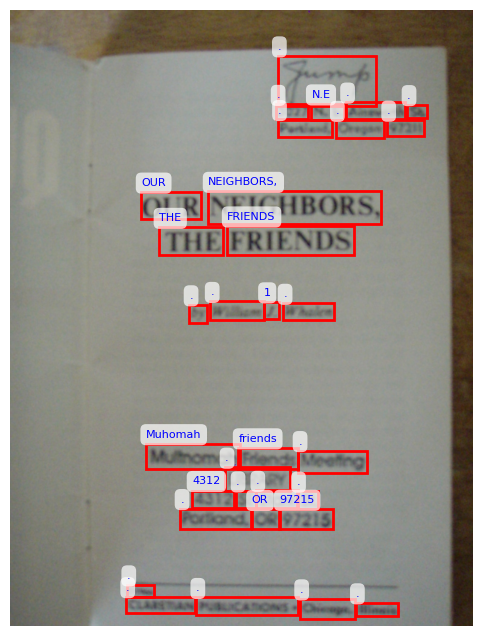

In [45]:
if os.path.exists(img_path):
    annotations = [data["anns"][ann_id] for ann_id in data["imgToAnns"].get(img_id, [])]
    visualize_annotations(img_path, annotations)
else:
    print(f"Image not found: {img_path}")

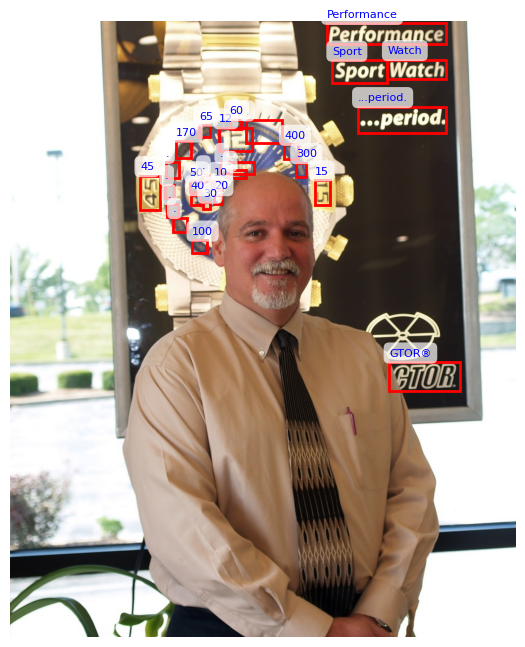

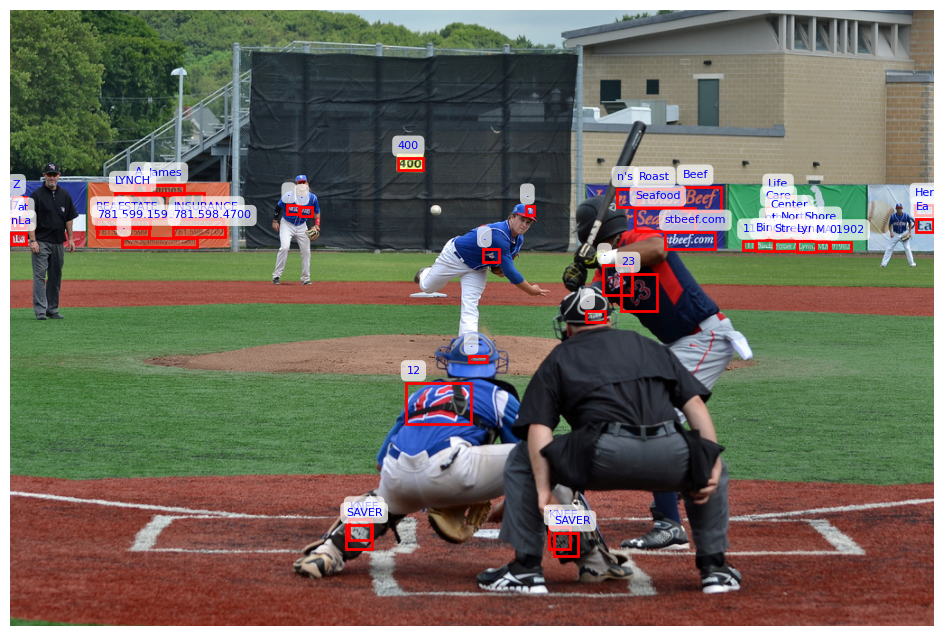

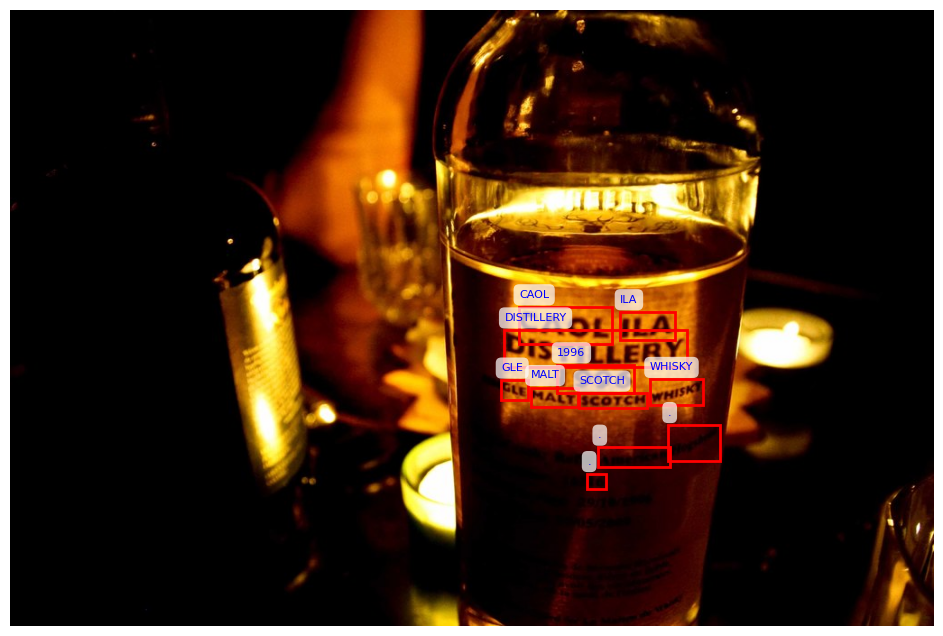

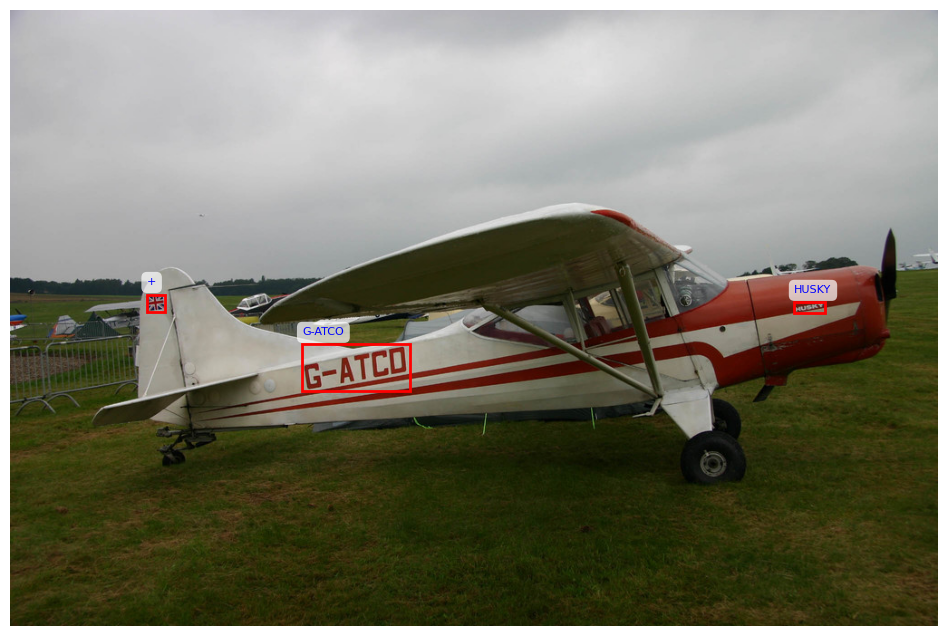

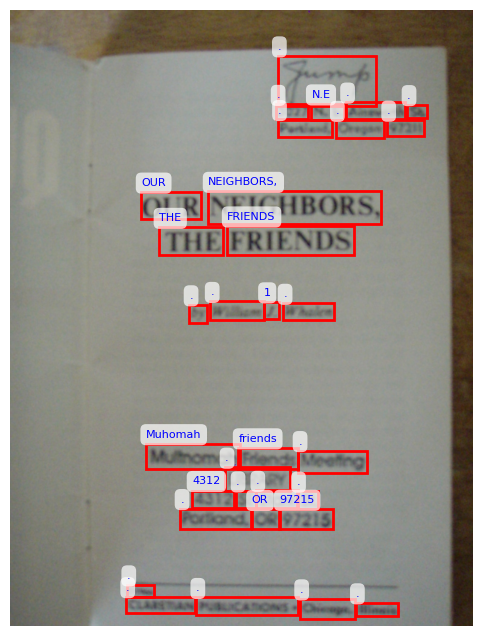

In [48]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to visualize annotations on images
def visualize_annotations(image_path, annotations):
    """
    Display image with bounding boxes and annotations.
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    # Load the image using matplotlib (plt.imread works with most image types)
    image = plt.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Loop through the annotations and add bounding boxes and text
    for ann in annotations:
        bbox = ann['bbox']  # Bounding box: [x, y, width, height]
        text = ann['utf8_string']  # Text annotation

        # Create a rectangle for the bounding box
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)

        # Display the text
        ax.text(
            bbox[0], bbox[1] - 10, text, color="blue", fontsize=8,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
        )

    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example usage: Loop through first 5 images and check the paths
for img_id, metadata in list(data["imgs"].items())[:5]:  # Adjust range as needed
    img_path = os.path.join(
        '/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/train_val_images/train_images',
        metadata["file_name"]
    )

    # Adjust path if there is an extra "train/" subdirectory
    if img_path.startswith("/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip (Unzipped Files)/train_val_images/train_images/train/"):
        img_path = img_path.replace("/train_val_images/train_images/train/", "/train_val_images/train_images/")

    # Check if the image exists
    if os.path.exists(img_path):
        annotations = [data["anns"][ann_id] for ann_id in data["imgToAnns"].get(img_id, [])]
        visualize_annotations(img_path, annotations)
    else:
        print(f"Image not found: {img_path}")

### Split the Data

In [49]:
# Splitting the Data to prepare for Model Training and Testing
def split_dataset(data, train_ratio=0.7, val_ratio=0.15):

    # Shuffle image IDs
    image_ids = list(data["imgs"].keys())
    random.shuffle(image_ids)

    # Calculate split indices
    train_end = int(len(image_ids) * train_ratio)
    val_end = train_end + int(len(image_ids) * val_ratio)

    # Split image IDs
    train_ids = image_ids[:train_end]
    val_ids = image_ids[train_end:val_end]
    test_ids = image_ids[val_end:]

    def create_subset(ids):
        subset = {"imgs": {}, "anns": {}, "imgToAnns": {}}
        for img_id in ids:
            subset["imgs"][img_id] = data["imgs"][img_id]
            subset["imgToAnns"][img_id] = data["imgToAnns"][img_id]
            for ann_id in data["imgToAnns"][img_id]:
                subset["anns"][ann_id] = data["anns"][ann_id]
        return subset

    # Create subsets
    train_data = create_subset(train_ids)
    val_data = create_subset(val_ids)
    test_data = create_subset(test_ids)

    return train_data, val_data, test_data

# Example usage: Split data
train_data, val_data, test_data = split_dataset(data, train_ratio=0.7, val_ratio=0.15)

print(f"Training set: {len(train_data['imgs'])} images")
print(f"Validation set: {len(val_data['imgs'])} images")
print(f"Testing set: {len(test_data['imgs'])} images")

Training set: 15244 images
Validation set: 3266 images
Testing set: 3268 images


### Prepare the Data

In [ ]:
# Prepare the Dataset
def prepare_dataset(dataset, max_text_length=32):
    images = []

    for img_id, metadata in tqdm(dataset["imgs"].items(), desc="Processing Images", unit="image", leave=False):
        img_path = metadata["file_name"]
        annotations = dataset["imgToAnns"][img_id]

        # Here we skip preprocessing if the data is already cleaned and ready
        for ann_id in annotations:
            ann = dataset["anns"][ann_id]
            # Text is already ready for use, no further encoding is needed
            text = ann['utf8_string']

            # Directly use the image (assuming it's already in the correct format)
            image = plt.imread(img_path)  # Just load the image as-is
            images.append(image)

    return np.array(images)

# Prepare datasets without additional preprocessing
X_train = prepare_dataset(train_data)
X_val = prepare_dataset(val_data)
X_test = prepare_dataset(test_data)

### Initiate CRNN Model

In [ ]:
# Initiate Model
def build_crnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Convolutional layers for feature extraction
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Reshape the feature map for RNN
    shape = x.shape
    x = Reshape((shape[1], shape[2] * shape[3]))(x)

    # Recurrent layers (LSTM) to capture sequence dependencies
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Compile the model
crnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("best_crnn_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Train the model
history = crnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stopping, checkpoint]
)

### Evaluate CRNN Model

In [ ]:
# Evaluate the CRNN Model
test_loss, test_accuracy = crnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call to plot
plot_training_history(history)

### Evaluation Metrics

In [ ]:
# Load and preprocess the image
image = preprocess_image("image1.jpg", target_size=(128, 32))

# Make a prediction using the model
predicted_text = model.predict(np.expand_dims(image, axis=0))  # Add batch dimension

# Convert predicted text to a human-readable form (if needed)
predicted_text = predicted_text[0]  # Assuming single prediction
print("Predicted Text:", predicted_text)

# Get the image and its annotations
img_id = "image_id_1"  # Example image ID
annotations = dataset["imgToAnns"][img_id]

# Loop through the annotations and get the ground truth text
ground_truth_text = []
for ann_id in annotations:
    ann = dataset["anns"][ann_id]
    text = ann["utf8_string"]
    ground_truth_text.append(text)

# Join all annotations if there are multiple per image
ground_truth_text = " ".join(ground_truth_text)
print("Ground Truth:", ground_truth_text)

In [ ]:
# Character Error Rate (CER)
def calculate_cer(predicted, ground_truth):
    matcher = SequenceMatcher(None, predicted, ground_truth)
    distance = sum(tag.size for tag in matcher.get_opcodes() if tag[0] != 'equal')
    return distance / len(ground_truth) if ground_truth else 1.0

# Word Error Rate (WER)
def calculate_wer(predicted, ground_truth):
    predicted_words = predicted.split()
    ground_truth_words = ground_truth.split()

    # Compute Levenshtein distance between word sequences
    distance = np.sum([1 for p, g in zip(predicted_words, ground_truth_words) if p != g])
    return distance / len(ground_truth_words) if ground_truth_words else 1.0

# Calculate Accuracy for OCR
def calculate_accuracy(predicted, ground_truth):
    """
    Compute the accuracy between predicted and ground truth text at the character level.
    """
    correct = sum(1 for p, g in zip(predicted, ground_truth) if p == g)
    return correct / len(ground_truth) if ground_truth else 1.0

# Example usage with ground truth and predictions from the model
ground_truth = "Performance"  # Replace with actual ground truth text
predicted_text = "Perfromnce"  # Replace with model's predicted text

# Calculate CER
cer = calculate_cer(predicted_text, ground_truth)
print(f"Character Error Rate (CER): {cer:.2%}")

# Calculate WER
wer = calculate_wer(predicted_text, ground_truth)
print(f"Word Error Rate (WER): {wer:.2%}")

# Calculate Accuracy
accuracy = calculate_accuracy(predicted_text, ground_truth)
print(f"Accuracy: {accuracy:.2%}")